###### May 11, 2022
###### Author: Lorenzo Meloncelli, Martina Manno, Valerio Schettini 
#### DATA VISUALIZATION PROJECT
# Amazon product co-purchasing network metadata

### The project has three following objectives:

1. Create plots in order  to extract interesting insight from the data.
2. Extract a network from the dataset
3. Visualise the network

### Import libraries required

In [3]:
import string
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from stemming.porter2 import stem
import networkx 
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pylab as plt
from IPython.display import Image
from community import community_louvain
from collections import Counter
from itertools import chain
#pyo.init_notebook_mode()
import plotly.io as pio
pio.renderers.default = 'browser'


The dataset is available on the Stanford Network Analysis Project (SNAP) website from the following link: http://snap.stanford.edu/data/amazon-meta.html

In [4]:
# Open the file to read Amazon Product Metadata
df = open ('amazon-meta.txt', 'r', encoding='utf-8', errors= 'ignore')

### Description of the dataset
The data was collected in summer 2006 by crawling the Amazon website. The dataset provides information about product metadata and review metadata on 548,552 different products. For each product in the dataset, the following informations are available:
- Title
- Salesrank
- List of similar products (that get co-purchased with the current product)
- Detailed product categorization
- Product reviews: time, customer, rating, number of votes, number of people that found the review helpful

The data format is:
- ID: Product number (number 0, …, 548551)
- ASIN: Amazon Standard Identification Number is a 10-character alphanumeric unique identifier assigned by Amazon.com for product identification
- Title: Name/title of the product
- Group: The product group can be Book, DVD, Video or Music
- Sales rank: The Amazon sales rank represents how a product is selling in comparison to other products in its primary category. The lower the rank, the better a product is selling
- Similar: ASINs of co-purchased products, such as people who buy X also buy Y
- Categories: Location in product category hierarchy to which the product belongs (separated by |, category id in [...] )
- Reviews: Product review information such as the total number of reviews, average rating and the individual customer review information including time, user id, rating, total number of votes on the review, total number of helpfulness votes which means how many people found the review to be helpful


 

### Dataset Preprocessing





In [5]:
# Initialize a nested product dictionary that will hold cleaned up amazon product data. 
amazonProducts= {}

Before jumping into the  network analysis, some preprocess is required to read the file and use ASIN as the key and the others as the metadata associated with ASIN.
- ID, ASIN, Title, Sales rank, Total reviews, and Average rating are the same as described above.
- All the categories associated with the ASIN are concatenated, and then the are subject to Text Preprocessing steps: lowercase, stemming, remove digit/punctuation, remove stop words, retain only unique words. 
- The copurchased ASINs in the “similar” field are filtered down to only those ASINs that have metadata associated with it.

In [6]:
# Read the data from the Amazon file and fill the amazonProducts nested dictionary
(Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)

for line in df:
    line = line.strip()
    if(line.startswith("Id")): # a product block started
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        ls = line.split()
        Copurchased = ' '.join([c for c in ls[2:]])
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((df.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ',Categories)
        Categories = ' '.join(set(Categories.split())-set(stopwords.words("english")))
        Categories = ' '.join(stem(word) for word in Categories.split())
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip() # a product block ended
    elif (line==""): # write out fields to amazonProducts dictionary
        try:
            MetaData = {}
            if (ASIN != ""):
                amazonProducts[ASIN] = MetaData
            MetaData['Id'] = Id
            MetaData['Title'] = Title
            MetaData['Categories'] = ' '.join(set(Categories.split()))
            MetaData['Group'] = Group
            MetaData['Copurchased'] = Copurchased
            MetaData['SalesRank'] = int(SalesRank)
            MetaData['TotalReviews'] = int(TotalReviews)
            MetaData['AvgRating'] = float(AvgRating)
            MetaData['DegreeCentrality'] = DegreeCentrality
            MetaData['ClusteringCoeff'] = ClusteringCoeff
        except NameError:
            continue
        (Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)
df.close

<function TextIOWrapper.close()>

Filter Amazon products dictionary down to only Group=Book and write it to amazonBooks dictionary.

In [7]:
#create book specific dictionary exclusively for books
amazonBooks = {}
for asin,metadata in amazonProducts.items():
    if (metadata['Group']=='Book'):
        amazonBooks[asin]=amazonProducts[asin]
        
#remove any copurchased items from copurchase list. If we don't have metadata associated with it
for asin, metadata in amazonBooks.items():
    amazonBooks[asin]['Copurchased']= ' '.join([cp for cp in metadata['Copurchased'].split() if cp in amazonBooks.keys()])
    

Use the copurchase data in Amazon books dictionary to create the copurchase graph structure as follows:
- NODES: are the ASINs
- EDGES: exist between two Nodes if the two ASINs were co-purchased
- EDGE WEIGHT: it is based on category similarity
- SIMILARITY: it is a measure between any two ASINs that were co-purchased and it can be calculated as the number of words that are common between categories of connected Nodes divided by the total number of words in both categories of connected nodes. The similarity range goes from 0 (most dissimilar) to 1 (most similar).

 

In [8]:
#create a product copurchase graph for analysis
#the graph nodes are product ASINs, the graph edge exists if two products were copurchased, with edge weight being a measure of category similarity between ASINs
copurchaseGraph = networkx.Graph()
for asin, metadata in amazonBooks.items():
    copurchaseGraph.add_node(asin)
    for a in metadata ['Copurchased'].split():
        copurchaseGraph.add_node(a.strip())
        similarity= 0
        n1= set((amazonBooks[asin]['Categories']).split())
        n2= set ((amazonBooks[a]['Categories']).split())
        n1In2 = n1 & n2 #intersection: number of words that are common between categories of connected nodes
        n1Un2 = n1 | n2 #union: total number of words in both categories of connected nodes
        if (len(n1Un2)) > 0:
            similarity = round (len(n1In2)/len(n1Un2), 2)
        copurchaseGraph.add_edge(asin, a.strip(), weight = similarity)

Add the graph-related measures for each ASIN node to the Amazon books dictionary: degree centrality and clustering coefficient.

In [9]:
# Get degree centrality and clustering coefficients of each node and add it to amazonBooks metadata.
dc = networkx.degree(copurchaseGraph)
for asin in networkx.nodes(copurchaseGraph):
    metadata = amazonBooks[asin]
    metadata['DegreeCentrality'] = int(dc[asin])
    ego = networkx.ego_graph(copurchaseGraph, asin, radius = 1)
    metadata['ClusteringCoeff'] = round(networkx.average_clustering(ego), 2)
    amazonBooks[asin] = metadata

Now, write out Amazon books data to the amazon-books.txt file and the copurchase graph data to the amazon-books-copurchase.edgelist file.


In [10]:
# Write amazonBooks data to file
df1 = open('./amazon-books.txt', 'w', encoding = 'utf-8', errors = 'ignore')
df1.write('Id\t' + 'ASIN\t' + 'Title\t'+
         'Categories\t' + 'Group\t' + 'Copurchased\t'+
         'SalesRank\t' + 'TotalReviews\t' + 'AvgRating\t'+
         'DegreeCentrality\t' + 'ClusteringCoeff\n')
for asin, metadata in amazonBooks.items():
    df1.write(metadata['Id'] + '\t' + 
              asin + '\t' +
              metadata['Title'] + '\t' +
              metadata['Categories'] + '\t' +
              metadata['Group'] + '\t' +
              metadata['Copurchased'] +'\t' + 
              str(metadata['SalesRank']) + '\t' +
              str(metadata['TotalReviews']) + '\t' +
              str(metadata['AvgRating']) + '\t' +
              str(metadata['DegreeCentrality']) + '\t' +
              str(metadata['ClusteringCoeff']) + '\n')
df1.close()

# Write copurchaseGraph to file
df1 = open('amazon-books-copurchase.edgelist', 'wb')
networkx.write_weighted_edgelist(copurchaseGraph, df1)
df1.close()

# Plots


In [11]:
df2= open('amazon-books-copurchase.edgelist')
copurchaseGraph = nx.read_weighted_edgelist(df2)
df2.close()

Degree and Degree Distribution

In [12]:
def degree_rank(net):
    degree_sequence = sorted((d for n, d in net.degree()), reverse=True)
    df = pd.DataFrame(degree_sequence, columns = ['Degree'])
    fig = px.scatter(df, y = 'Degree')
    fig.update_layout(xaxis_title="Rank")
    fig.update_layout({
        'plot_bgcolor' : 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    })
    return fig
degree_rank(copurchaseGraph)

In [ ]:
def degree_hist(net, kind = None, group = False):
    if kind == 'in':  degrees = net.in_degree()
    elif kind == 'out':  degrees = net.out_degree()
    else: degrees = net.degree()
   
    df = pd.DataFrame(degrees, columns = ['Node', 'Degree'])
    nbins = None if group else len(degrees)
    fig = px.histogram(df, x="Degree", nbins = nbins )
    fig.update_layout(yaxis_title="# of Nodes", bargap=0.01)
    fig.update_layout({
        'plot_bgcolor' : 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    })
    return fig  

degree_hist(copurchaseGraph)

# Network analysis


In [ ]:
# Check connection
nx.is_connected(copurchaseGraph)

In [ ]:
# Average degree
sum(dict(copurchaseGraph.degree()).values()) / nx.number_of_nodes(copurchaseGraph)

In [ ]:
# Number of connected components
nx.number_connected_components(copurchaseGraph)

In [ ]:
# Clustering coefficient of all nodes (in a dictionary)
nx.clustering(copurchaseGraph)

In [ ]:
# Average clustering coefficient
nx.average_clustering(copurchaseGraph)

In [ ]:
# The density tells us how many of the possible edges in the graph are actually present:
nx.density(copurchaseGraph)

In [ ]:
sum(nx.triangles(copurchaseGraph).values()) / 3

In [ ]:
deg_cen_g_copurchase = nx.degree_centrality(copurchaseGraph)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[0:50]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]
degree = [j for i,j in sorted_deg_cen_g_copurchase]
custom_palette1 = sns.color_palette("mako", 50)
custom_palette2 = sns.color_palette("light:b", 50)
custom_palette2.reverse()
sns.set(rc={'figure.figsize':(15,10), 'axes.facecolor':'white'})
ax = sns.barplot(x = ASIN, y = degree, palette = custom_palette1)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

In [ ]:
mean_weights = []
for j in ASIN:
    neigh = copurchaseGraph.edges(j, data= True)
    weight = []
    for i in neigh:
        weight.append(i[2]['weight'])
    weight
    mean_weights.append(np.mean(weight))
mean_weights  
print('Mean of similarity between most connected nodes: ', np.mean(mean_weights))

In [ ]:
l = list(copurchaseGraph.edges(data= True))
total_weights = []
for i in l:
    total_weights.append(i[2]['weight'])
total_mean_weights = np.mean(total_weights)
print('Mean of similarity between all nodes: ', total_mean_weights)

The average weight of the edges of the nodes that have a higher degree centrality tends to be lower than the average total weight of the edges of the graph. therefore, the co-purchase of two books would seem not to derive exclusively from the characteristics of the books themselves, but also from other factors that are not taken into consideration here. For these reason, the advise could be not to  develop a recommendation system that is only content-based, but a hybrid one that also takes into account other factors such as users' tastes.

# Sample analysis

From now on, only the sample will be considered for analysis because of the visualisation complexity due to the size of the dataset. Rather than selecting nodes at random,a good criterion would have been to select a small number of nodes with the highest degree centrality. This is because nodes with this characteristic represent books with the highest number of co-purchases, therefore this selection allows us to carry as much information as possible while still consistently reducing the number of observations.

In [13]:
df2 = open('amazon-books-copurchase.edgelist', 'r')
data = nx.read_weighted_edgelist(df2)
df2.close()
c = list(data.edges(data = True))
fr = []
to = []
weight = []
deg_cen = []
deg_cen_g_copurchase = nx.degree_centrality(data)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[0:50]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]

for i in c:
    if i[0] in ASIN:
        fr.append(i[0])
        to.append(i[1])
        weight.append(i[2]['weight'])
        deg_cen.append(dict(sorted_deg_cen_g_copurchase)[i[0]])

edges = {'Source': fr, 'Target': to, 'Weight' : weight, 'Degree Centrality': deg_cen}
df = pd.DataFrame(edges)
df.to_csv('Highest degree centrality nodes.csv', index = False)

In [14]:
sample = pd.read_csv('Highest degree centrality nodes.csv')
sample = pd.DataFrame(sample)
g = nx.from_pandas_edgelist(sample, 'Source', 'Target', ['Weight'])

In [15]:
# Check connection
nx.is_connected(g)

False

In [16]:
# Average degree
sum(dict(g.degree()).values()) / nx.number_of_nodes(g)

2.3139312977099236

In [17]:
# Number of connected components
nx.number_connected_components(g)

15

In [21]:
# Clustering coefficient of all nodes (in a dictionary)
nx.clustering(g)

{'0071360387': 0,
 '0838514944': 0,
 '0781719682': 0,
 '0323019765': 0,
 '0815137621': 0,
 '0443070385': 0,
 '0781717078': 0,
 '0803603649': 0,
 '032301335X': 0,
 '0838581358': 0,
 '0323008283': 0,
 '0964615134': 0,
 '0815130341': 0,
 '0803602294': 0,
 '0323018777': 0,
 '0397554729': 0,
 '0781732034': 0,
 '0781716594': 0,
 '0192632701': 0,
 '0803605935': 0,
 '0071383360': 0,
 '0071391029': 0,
 '0721674682': 0,
 '0781714303': 0,
 '0838522106': 0,
 '1560550988': 0,
 '081517148X': 0,
 '0070220670': 0,
 '0683304828': 0,
 '0781718767': 0,
 '0721694063': 0,
 '0323017126': 0,
 '0781729947': 0,
 '0323001483': 0,
 '0721672299': 0,
 '0781717302': 0,
 '0781737532': 0,
 '081515903X': 0,
 '0721679714': 0,
 '0815188986': 0,
 '0387949585': 0,
 '0721686923': 0,
 '0721677436': 0,
 '1883205441': 0,
 '0803605382': 0,
 '0838514014': 0,
 '0781721709': 0,
 '0721682464': 0,
 '0632047585': 0,
 '0683305891': 0,
 '072168002X': 0,
 '0683305174': 0,
 '0632043229': 0,
 '0070653518': 0,
 '0323000290': 0,
 '03230025

In [22]:
# Average clustering coefficient
nx.average_clustering(g)

0.13886747391765145

In [23]:
# The density tells us how many of the possible edges in the graph are actually present:
nx.density(g)

0.0003680501507411999

In [24]:
centr = nx.betweenness_centrality(g)
centr_df = pd.DataFrame(centr.items(), columns = ['Node', 'Betweeness'])
centr_df

KeyboardInterrupt: 

In [25]:
sum(nx.triangles(g).values()) / 3

1003.0

# Network Visualization

## Networkx

To get some insights from the new sample, the first step is to analyze its degeneracy.
A k-core of a graph G is a maximal connected subgraph of G in which all vertices have degree at least k. 
Equivalently, it is one of the connected components of the subgraph of G formed by repeatedly deleting all vertices of degree less than k. 
If a non-empty k-core exists, then, clearly, G has degeneracy at least k, and the degeneracy of G is the largest k for which G has a k-core.



In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
pos = nx.spring_layout(g, k=0.1)
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    g,
    pos=pos,
    node_size=0,
    edge_color="#444444",
    alpha=0.06,
    with_labels=False)

In [ ]:
# Cores with at lest degree 2
G_core_2 = nx.k_core(g, 2)
# Similarly, with at least degree 3
G_core_3 = nx.k_core(g, 3)
# Visualize network and k-cores
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(g, k=0.1)
nx.draw_networkx(
    g, pos=pos, node_size=0, edge_color="#333333", alpha=0.04, with_labels=False)
nx.draw_networkx(
    G_core_2, pos=pos, node_size=0, edge_color="green", alpha=0.05, with_labels=False) 
nx.draw_networkx(
    G_core_3, pos=pos, node_size=0, edge_color="red", alpha=0.05, with_labels=False)

As you can see, only a few nodes in the graph have more than two neighbors (subgraph in red). 
In other words, it is rare to find set of books where each of the books has at least two other books purchased with it. The reference sample is made out of the 50 nodes with highest degree centrality. Therefore, in most cases there are books that are not co-purchased with each other, but with only one specific book, always present in the cart with the others.

The following three graphs show the adjeciency matrices for three subsets of the nodes sorted by degree centrality.
You can see how sorting nodes according to this metric shows an interesting structure where the sparsity of the matrix increases as the degree centrality of nodes diminishes.

In [ ]:
# Adjcency matrix for first 50 sorted nodes
# Reduce the dataset to the 50 nodes with highest degree centrality and their neighbors
deg_cen_g_copurchase = nx.degree_centrality(copurchaseGraph)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[0:50]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]
c = list(copurchaseGraph.edges(data = True))
fr = []
to = []
weight = []
deg_cen = []

for i in c:
    if i[0] in ASIN:
        fr.append(i[0])
        to.append(i[1])
        weight.append(i[2]['weight'])
        deg_cen.append(dict(sorted_deg_cen_g_copurchase)[i[0]])

edges = {'From Node': fr, 'To Node': to, 'Weight' : weight, 'Degree Centrality': deg_cen}
df1 = pd.DataFrame(edges)
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')

# Adjcency matrix for first 50 sorted nodes
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')
adj = nx.adjacency_matrix(G, weight='Weight')
print(adj.shape)
plt.spy(adj)

In [ ]:
deg_cen_g_copurchase = nx.degree_centrality(copurchaseGraph)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[50:250]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]
c = list(copurchaseGraph.edges(data = True))
fr = []
to = []
weight = []
deg_cen = []

for i in c:
    if i[0] in ASIN:
        fr.append(i[0])
        to.append(i[1])
        weight.append(i[2]['weight'])
        deg_cen.append(dict(sorted_deg_cen_g_copurchase)[i[0]])

edges = {'From Node': fr, 'To Node': to, 'Weight' : weight, 'Degree Centrality': deg_cen}
df1 = pd.DataFrame(edges)
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')

# Adjcency matrix for sorted nodes from 100 to 250
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')
adj1 = nx.adjacency_matrix(G, weight='Weight')
print(adj1.shape)
plt.spy(adj1)




In [ ]:
deg_cen_g_copurchase = nx.degree_centrality(copurchaseGraph)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[250:450]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]
c = list(copurchaseGraph.edges(data = True))
fr = []
to = []
weight = []
deg_cen = []

for i in c:
    if i[0] in ASIN:
        fr.append(i[0])
        to.append(i[1])
        weight.append(i[2]['weight'])
        deg_cen.append(dict(sorted_deg_cen_g_copurchase)[i[0]])

edges = {'From Node': fr, 'To Node': to, 'Weight' : weight, 'Degree Centrality': deg_cen}
df1 = pd.DataFrame(edges)
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')
# Adjcency matrix for sorted nodes from 260 to 450
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')
adj2 = nx.adjacency_matrix(G, weight='Weight')
print(adj2.shape)
plt.spy(adj2)

## Gephi

In order to visualize the network graph, also the Yifan Hu algorithm can be used. It is a kind of force directed layout, the purpose of which is to minimize edge crossings while also minimizing the number of edge bends. In this case the choice of plotting a sample of the original dataset is justified by some limiting factor the force-directed layout algorithms are subject to. Namely, the high probability, for very large networks, to end up in a suboptimal configuration and the computational complexity of the algorithm itself. To overcome the first limit the algorithm uses a multilevel approach which effectively overcomes local minimums. To solve the second one, the technique use efficient approximations of short and long range forces. 

In [ ]:
Image(filename = "Yifan Hu Communities.png", width=750, height=750)

To our surprise, by first using the Yifan Hu method to draw the graph and then applying the Louvain algorithm to find communities, the layout configuration overlaps perfectly with the communities found. The result from this two step process is as follows: most of the nodes that have a high degree centrality are connected to nodes that in turn are not connected to other nodes. Moreover, nodes with high degree centrality have the tendency to connect communities with each other either directly or through some other nodes between communities. Therefore, it is possible to clearly visualize not only books having a lot of other books purchased with them, but also what are the books one has to co-purchase to pass from one community to another. For recommendations this means that there is a trade off between proposing a book to be co-purchased with another one but that reduces the probability of having a third book inserted in the cart or choosing a book that increments this probability. 

## Communities insights

In [26]:
communities =community_louvain.best_partition(g)

[Text(0, 0, 'book'),
 Text(1, 0, 'subject'),
 Text(2, 0, 'children'),
 Text(3, 0, 'general'),
 Text(4, 0, 'fiction'),
 Text(5, 0, 'babi'),
 Text(6, 0, 'anim'),
 Text(7, 0, 'z'),
 Text(8, 0, 'author'),
 Text(9, 0, 'illustr'),
 Text(10, 0, 'specialti'),
 Text(11, 0, 'store'),
 Text(12, 0, 'music'),
 Text(13, 0, 'age'),
 Text(14, 0, 'pictur'),
 Text(15, 0, 'literatur'),
 Text(16, 0, 'place'),
 Text(17, 0, 'peopl'),
 Text(18, 0, 'concept'),
 Text(19, 0, 'basic')]

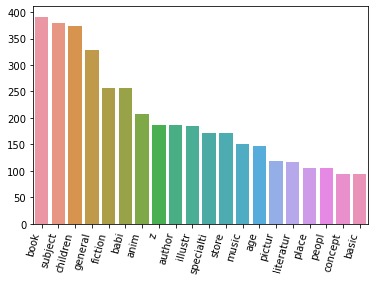

In [27]:
data = pd.read_csv('Modularity_class_sample.csv')
data_5 = data[data['modularity_class'] == 13]

l = list(data_5['Id'])
m = list(amazonBooks.items())
categories = []

for node in l:
    for book in m:
        if node == book[0]:
            categories.append(book[1]['Categories'])

cat = []
for i in categories:
    m = i.split()
    for l in m:
        cat.append(l)
        
occur = Counter(cat)

sorted_dict = {}
sorted_keys = sorted(occur, key=occur.get, reverse=True)  

for w in sorted_keys:
    sorted_dict[w] = occur[w]
    
keys = list(sorted_dict.keys())[:20]
vals = list(sorted_dict.values())[:20]
a = sns.barplot(x=keys, y = vals)
a.set_xticklabels(a.get_xticklabels(), rotation=75, horizontalalignment='right')

[Text(0, 0, 'book'),
 Text(1, 0, 'subject'),
 Text(2, 0, 'children'),
 Text(3, 0, 'general'),
 Text(4, 0, 'fiction'),
 Text(5, 0, 'babi'),
 Text(6, 0, 'anim'),
 Text(7, 0, 'z'),
 Text(8, 0, 'author'),
 Text(9, 0, 'illustr'),
 Text(10, 0, 'specialti'),
 Text(11, 0, 'store'),
 Text(12, 0, 'music'),
 Text(13, 0, 'age'),
 Text(14, 0, 'pictur'),
 Text(15, 0, 'literatur'),
 Text(16, 0, 'place'),
 Text(17, 0, 'peopl'),
 Text(18, 0, 'concept'),
 Text(19, 0, 'basic')]

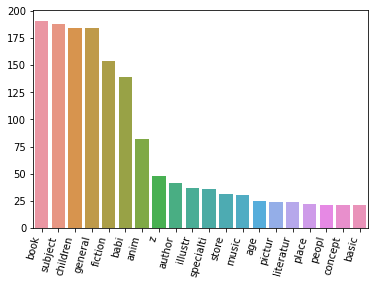

In [28]:
data_3 = data[data['modularity_class'] == 23]

l = list(data_3['Id'])
m = list(amazonBooks.items())
categories = []

for node in l:
    for book in m:
        if node == book[0]:
            categories.append(book[1]['Categories'])

cat = []
for i in categories:
    m = i.split()
    for l in m:
        cat.append(l)
        
occur = Counter(cat)

sorted_dict = {}
sorted_keys = sorted(occur, key=occur.get, reverse=True)  

for w in sorted_keys:
    sorted_dict[w] = occur[w]
    
keys = list(sorted_dict.keys())[:20]
vals = list(sorted_dict.values())[:20]
b = sns.barplot(x=keys, y = vals)
b.set_xticklabels(a.get_xticklabels(), rotation=75, horizontalalignment='right')

[Text(0, 0, 'book'),
 Text(1, 0, 'subject'),
 Text(2, 0, 'children'),
 Text(3, 0, 'general'),
 Text(4, 0, 'fiction'),
 Text(5, 0, 'babi'),
 Text(6, 0, 'anim'),
 Text(7, 0, 'z'),
 Text(8, 0, 'author'),
 Text(9, 0, 'illustr'),
 Text(10, 0, 'specialti'),
 Text(11, 0, 'store'),
 Text(12, 0, 'music'),
 Text(13, 0, 'age'),
 Text(14, 0, 'pictur'),
 Text(15, 0, 'literatur'),
 Text(16, 0, 'place'),
 Text(17, 0, 'peopl'),
 Text(18, 0, 'concept'),
 Text(19, 0, 'basic')]

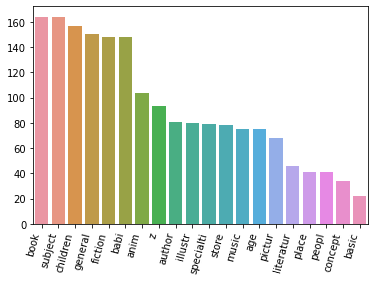

In [29]:
data_17 = data[data['modularity_class'] == 26]

l = list(data_17['Id'])
m = list(amazonBooks.items())
categories = []

for node in l:
    for book in m:
        if node == book[0]:
            categories.append(book[1]['Categories'])

cat = []
for i in categories:
    m = i.split()
    for l in m:
        cat.append(l)
        
occur = Counter(cat)

sorted_dict = {}
sorted_keys = sorted(occur, key=occur.get, reverse=True)  

for w in sorted_keys:
    sorted_dict[w] = occur[w]
    
keys = list(sorted_dict.keys())[:20]
vals = list(sorted_dict.values())[:20]
c = sns.barplot(x=keys, y = vals)
c.set_xticklabels(a.get_xticklabels(), rotation=75, horizontalalignment='right')

In [ ]:
edge_style_def = dict(color = 'gray', width = 0.5)  # define the default style for edges
node_style_def = dict(symbol = 'circle', size = 5, opacity = 0.9, 
                      color = 'blue', line = dict(color = 'rgb(0,0,0)', width = 0.5))   # define the default style for nodes

In [ ]:
def set_layout(G, ndim = 2, kamada = True):    
    print('Calculating coordinates')
    layout = nx.kamada_kawai_layout(G, dim = ndim) if kamada else nx.spring_layout(G, dim = ndim) # define the node layout with NetworkX
    print('End')
    edgelist = list(G.edges())
    
    # Extract coordinates
    ax_nodes = pd.DataFrame(layout).transpose() 
    ax_nodes.columns = ['X', 'Y'] if ndim == 2 else ['X', 'Y', 'Z'] # 2D or 3D?
    
    
    # define layout for edges
    if ndim == 2:
        layout_e = dict(map(lambda e: 
                (e, # edge key
                ([layout[e[0]][0], layout[e[1]][0], None],  # X
                [layout[e[0]][1], layout[e[1]][1], None])  # Y
                ), edgelist))
    else:
        layout_e = dict(map(lambda e: 
            (e, # edge key
            ([layout[e[0]][0], layout[e[1]][0], None], # X
            [layout[e[0]][1], layout[e[1]][1], None],  # Y
            [layout[e[0]][2], layout[e[1]][2], None])  # Z
            ), edgelist))
    
    
    # extract coordinates
    ax_edges = pd.DataFrame(layout_e).transpose()
    ax_edges.columns = ['X', 'Y'] if ndim == 2 else ['X', 'Y', 'Z']

    return ax_nodes, ax_edges

In [ ]:
def set_trace(X, Y, kind, style, name, Z = None, text = None): #draw nodes or edges
    mode = 'markers' if kind == 'node' else 'lines'
    hoverinfo = 'text' if kind == 'node' else 'none'
    if Z is None:
        if kind == 'node':
            return go.Scatter(x = X, y = Y, mode = mode, name = name, marker = style, text = text, hoverinfo = hoverinfo)  # draw nodes (i.e., markers) in 2D
        else:
            return go.Scatter(x = X, y = Y, mode = mode, name = name, line = style, text = text, hoverinfo = hoverinfo)  # draw edges (i.e., lines) in 2D
    else: 
        if kind == 'node':
            return go.Scatter3d(x = X, y = Y, z = Z, mode = mode, marker = style,  text = text, name = name, hoverinfo = hoverinfo)  # draw nodes (i.e., markers) in 3D
        else:
            return go.Scatter3d(x = X, y = Y, z = Z, mode = mode, line = style,  text = text, name = name, hoverinfo = hoverinfo)  # draw edges (i.e., lines) in 3D

    
def set_traces(nodes_ax: pd.DataFrame, edges_ax: pd.DataFrame, communities = None):  # Function to set up the main figure with nodes, edges, and communities
    traces = []
    Xe = list(chain(*edges_ax.X.tolist())) 
    Ye = list(chain(*edges_ax.Y.tolist()))
    Ze = list(chain(*edges_ax.Z.tolist())) if 'Z' in edges_ax.columns else None

    traces.append(set_trace(Xe, Ye, Z = Ze, kind = 'edge', style = edge_style_def, name = 'Link'))
    
    if communities is None:
        traces.append(set_trace(nodes_ax.X.tolist(), nodes_ax.Y.tolist(), 
                                Z = nodes_ax.Z.tolist() if 'Z' in nodes_ax.columns else None, 
                                kind = 'node', style = node_style_def, 
                                name = 'Character', text = nodes_ax.index))
    else:
        colors = list(sns.color_palette(n_colors =len(communities)).as_hex())
        for idcom, community in enumerate(communities):
            node_style = node_style_def.copy()
            node_style['color'] = colors[idcom]
            temp = nodes_ax[nodes_ax.index.isin(community)]
            traces.append(set_trace(temp.X.tolist(), temp.Y.tolist(), 
                                Z = temp.Z.tolist() if 'Z' in temp.columns else None, 
                                kind = 'node', style = node_style, 
                                name = 'Class '+str(idcom), text = temp.index))
            
                                       
    return traces

In [ ]:
def draw_plotly_network(net, ndim = 2, communities = None, kamada = True):  # Main function to draw a network
    nodes_ax, edges_ax = set_layout(net, ndim = ndim, kamada = kamada)  # the kamada parameter sets the Networkx layout to use. The ndim parameter sets the dimensions the layout (i.e., 2D or 3D)
    traces = set_traces(nodes_ax, edges_ax, communities)  # the kamada parameter set the Networkx layout to use.
    pyo.iplot(traces, filename = 'basic-line')  # Plot the the network

In [ ]:
draw_plotly_network(g, ndim = 3, communities = comm_mod)  # Draw the network using the Kamada Kawai 3D layout

As you can see, by isolating class 13, we have the confirmation of what we discovered previously with the degeneracy analysis: in most cases the books are not co-purchased with each other, but with only one specific book which, in this specific case, is the book 0812580036.

## Recommendation system

The next step is to use this transformed data to make Book Recommendations. At first, read amazon-books.txt data into the amazonBooks Dictionary and amazon-books-copurchase.edgelist into the copurchaseGraph Structure.

In [ ]:
#code 1

We then assume a User has purchased a Book with ASIN=0805047905. The question then is, how do we make other Book Recommendations to this User, based on the Book copurchase data that we have? We could potentially take ALL books that were ever copurchased with this book, and recommend all of them. However, the Degree Centrality of Nodes in a Product Co-Purchase Network can typically be pretty large. We should therefore come up with a better strategy.
We examine the metadata associated with the Book that the User is looking to purchase (purchasedAsin =0805047905), including Title, SalesRank, TotalReviews, AvgRating, DegreeCentrality, and ClusteringCoefficient. We notice that this Book has a DegreeCentrality of 216 — which means 216 other Books were copurchased with this Book by other Customers. So yes, it would indeed make sense to come up with a better strategy of recommending copruchased Books.


In [ ]:
#code 2

Lets get the books that have been co-purchased with the purchasedAsin in the past. That is, get the depth-1 ego network of purchasedAsin from copurchaseGraph, and assign the resulting graph to purchasedAsinEgoGraph.


In [ ]:
#code 3

Filter down to the most similar books. That is, use the island method on purchasedAsinEgoGraph to only retain edges with threshold >= 0.5, and assign resulting graph to purchasedAsinEgoTrimGraph. And get the books that are still connected to the purchasedAsin by one hop (called the neighbors of the purchasedAsin) after the above clean-up. This has already been coded up for you. Assuming you’ve constructed the purchasedAsinEgoTrimGraph above, the list of neighbors is available in purchasedAsinNeighbors.

In [ ]:
#code4


Come up with a method to make the Top Five book recommendations based on one or more of the following metrics associated with neighbors in purchasedAsinNeighbors: SalesRank, AvgRating, TotalReviews, DegreeCentrality, and ClusteringCoeff. Think through this carefully… For instance, if you go with AvgRating, should you also consider TotalReviews in conjunction? Or if you go with ClusteringCoeff, can it be trivially 1? In which case, what other metric can you use in conjunction to avoid this situation?

In [ ]:
#code 5

Finally, we can print Top 5 recommendations (ASIN, and associated Title, Sales Rank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff).

In [ ]:
#code6

Result of the book recommendation
Since I set the specific ASIN (0805047905) in the book recommendation process 2, I could get the top 5 book recommendations including “Time for Bed”, “Big Red Barn Board Book”, “What Makes a Rainbow?: Pop-Up”, From Head to Toe Board Book”, and “From Head to Toe” as the result.